#### Exploring and diagnosing the exclusions from profiling the LRI dataset of ~45,000 substances.

- Profiling the LRI dataset
- Proposing refinements to the exclusion rules within Toxtree



Prepared by: G Patlewicz  <br>
Modified: 15th August 2022 <br>
Revised following reviewer comments to manuscript. 
Additional comments provided to clarify connection to manuscript figures and tables.

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import openpyxl
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

#### Profiling the LRI data as processed through the Nelms et al (2019) manuscript

In [5]:
lri = pd.read_csv(raw_dir+'LRI_TTC_updated_180719.csv')

How many unique substances are included in the dataset based on the DTXSID?

In [6]:
lri.DTXSID.nunique()

45038

In [7]:
lri.mark_ttc_class.unique()

array(['Genotoxicity Alert', 'Class III', 'NA for TTC', 'OP/Carbamate',
       'Class I', nan, 'Class II'], dtype=object)

In [8]:
exclusions = lri[lri.mark_ttc_class == 'NA for TTC']

In [9]:
len(exclusions)

4002

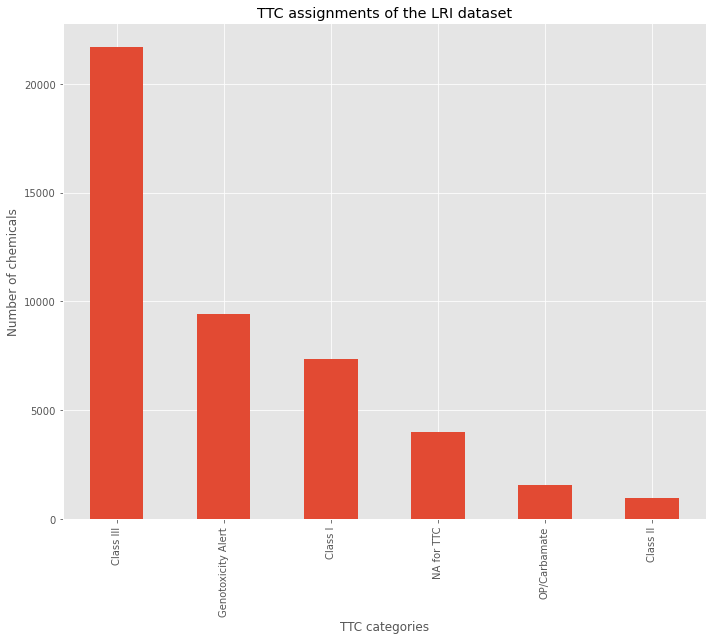

In [10]:
plt.style.use('ggplot')
plt.figure(figsize = (10,9))
plt.title('TTC assignments of the LRI dataset')
plt.xlabel('TTC categories')
plt.ylabel('Number of chemicals')
lri.mark_ttc_class.value_counts().plot.bar()
plt.tight_layout()
#plt.savefig(figures_dir+'TTC_category_counts.png', dpi = 300)

#### Table 1: Initial assignment of TTC categories for the LRI dataset

In [11]:
lri.mark_ttc_class.value_counts(dropna = False)


Class III             21691
Genotoxicity Alert     9422
Class I                7370
NA for TTC             4002
OP/Carbamate           1580
Class II                952
NaN                      21
Name: mark_ttc_class, dtype: int64

In [12]:
lri.mark_ttc_class.value_counts(dropna = False, normalize = True)

Class III             0.481616
Genotoxicity Alert    0.209201
Class I               0.163640
NA for TTC            0.088858
OP/Carbamate          0.035081
Class II              0.021138
NaN                   0.000466
Name: mark_ttc_class, dtype: float64

In [13]:
lri.mark_ttc_class.unique()

array(['Genotoxicity Alert', 'Class III', 'NA for TTC', 'OP/Carbamate',
       'Class I', nan, 'Class II'], dtype=object)

In [14]:
lri.shape

(45038, 16)

#### Figure S1: Pie chart of TTC assignments for the 45,017 substances within the LRI dataset

(-1.1253051884644207,
 1.1037945873741593,
 -1.1314282122848327,
 1.101496581537373)

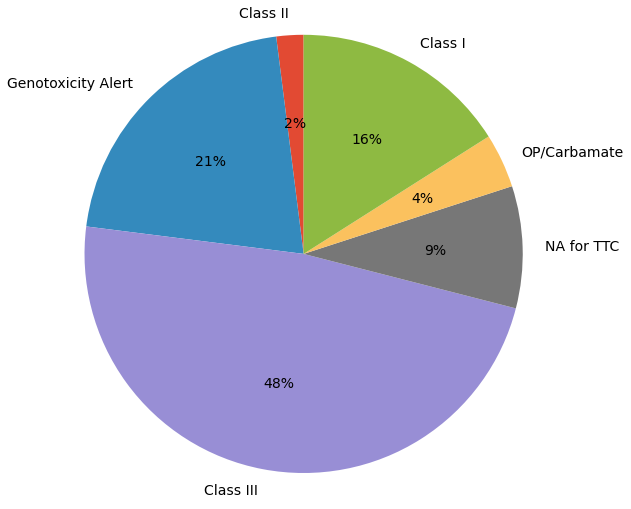

In [15]:
labels = ['Class II','Genotoxicity Alert', 'Class III', 'NA for TTC', 'OP/Carbamate',
       'Class I']
sizes = [2, 21, 48, 9, 4, 16]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (10,9))
ax1.pie(sizes,  labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90, textprops = {'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#fig1.savefig(figures_dir+'TTC_category_counts_pie.png', dpi = 300)

In [16]:
lri.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class
0,72-20-8,DTXSID6020561,Endrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000291,0.002280,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert
1,60-57-1,DTXSID9020453,Dieldrin,ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl,99,NaN,0.000553,0.009572,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert
2,87818-31-3,DTXSID3034456,Cinmethylin,CC(C)C12CCC(C)(O1)C(C2)OCC1=C(C)C=CC=C1,99,NaN,0.050130,0.445990,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III
3,76738-62-0,DTXSID2024242,Paclobutrazol,CC(C)(C)C(O)C(CC1=CC=C(Cl)C=C1)N1C=NC=N1,99,NaN,0.239110,2.872300,0.001500,Cramer Class III,Substance would not be expected to be a safety...,YES,NO,Class III,NaN,Class III
4,87674-68-8,DTXSID4032376,Dimethenamid,COCC(C)N(C(=O)CCl)C1=C(C)SC=C1C,99,NaN,1.564200,15.084000,0.000003,Genotoxicity Alert,Negligible risk (low probability of a life-tim...,YES,NO,Genotoxicity Alert,NaN,Genotoxicity Alert


#### Table S1: Breakdown of rationale for substances that were not applicable for TTC

In [17]:
exclusions.reason_for_NA.value_counts()

Yes to Q1                  3759
High Potency Carcinogen     241
Steroid                       2
Name: reason_for_NA, dtype: int64

In [18]:
exclusions[exclusions['reason_for_NA'] == 'High Potency Carcinogen'].head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class
182,101-25-7,DTXSID5020526,"N,N-Dinitrosopentamethylenetetramine",O=NN1CN2CN(C1)CN(C2)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,High Potency Carcinogen,NA for TTC
185,924-16-3,DTXSID2021026,N-Nitrosodibutylamine,CCCCN(CCCC)N=O,99,NaN,0.78521,7.5718,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,YES,YES,NA for TTC,High Potency Carcinogen,NA for TTC
262,1116-54-7,DTXSID7021027,N-Nitrosodiethanolamine,OCCN(CCO)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,High Potency Carcinogen,NA for TTC
263,100-75-4,DTXSID8021060,N-Nitrosopiperidine,O=NN1CCCCC1,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,High Potency Carcinogen,NA for TTC
265,55-18-5,DTXSID2021028,N-Nitrosodiethylamine,CCN(CC)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,High Potency Carcinogen,NA for TTC


#### Kroes ruleset as extracted from Toxtree
- To better elucidate the decision logic implemented to reflect the Kroes et al (2004) paper

In [19]:
kroes_set = pd.read_csv(external_dir+'kroes-rules.csv')

In [20]:
gentox_alerts = kroes_set[kroes_set['ID'].str.contains('SA')]

In [21]:
gentox_alerts[['ID', 'Title']].head()

,ID,Title
2,SA1_gen,Acyl halides
3,SA2_gen,Alkyl (C<5) or benzyl ester of sulphonic or ph...
4,SA3_gen,N-methylol derivatives
5,SA4_gen,Monohaloalkene
6,SA5_gen,S or N mustard


In [22]:
gentox_dict = { k:v for (k,v) in zip(gentox_alerts['ID'], gentox_alerts['Title'])}

In [23]:
#gentox_dict

#### alpha, beta as greek letters are rendered as ?. Manually editing these for clarity

In [24]:
gentox_dict['SA10_gen'] = 'a,b unsaturated carbonyls'

In [25]:
gentox_dict['SA24_gen'] =  'a,b unsaturated alkoxy'

#### How many DNA-reactive alerts comprise the set used in the Kroes module?

In [26]:
len(gentox_dict)

33

#### Re-evaluating Question 1

#### What are essential metals? See https://www.sciencedirect.com/science/article/pii/S0162013418306846
- essential metals: Na, K, Mg, Ca, Fe, Mn, Co, Cu, Zn and Mo

In [27]:
def has_metal_atom(smiles):
    metal_dict = {'Na': 11 , 'Mg': 12, 'Si': 14, 'K':19, 'Ca':20, 'Mn':25, 'Fe':26, 'Cu':29, 'Zn':30, 'Co':27, 'Ni':28, 'As': 33, 'Cr':24, 'Hg':80, 'Pb':82, 'V':23, 'Al':13, 'Ag':47, 'Cd':48, 'B':5, 'Ti': 22, 'Se': 34, 'Sn': 50, 'Sb':51, 'Be': 4, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Te':52, 'Ba':56, 'W':74, 'Au': 79, 'Bi': 83}
    essential_metal_dict = {'Na': 11 , 'K':19,'Mg': 12,  'Ca':20, 'Fe':26,  'Mn':25, 'Co':27, 'Cu':29, 'Zn':30, 'Mo': 42}
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(atom for atom in mol.GetAtoms() if atom.GetAtomicNum() in list(metal_dict.values()))

In [28]:
len([has_metal_atom(e) for e in exclusions['smiles']])

RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:41] WARNING: not r

4002

In [29]:
def metal_ions(smiles):
    essential_metal = ['[Na+]', '[K+]', '[Mg++]',  '[Ca++]', '[Fe+3]',  '[Mn++]', '[Co+]', '[Cu++]', '[Zn++]', '[Mo++]']
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(mol.HasSubstructMatch(Chem.MolFromSmarts(e)) for e in essential_metal)

In [30]:
def P_inorg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return mol.HasSubstructMatch(Chem.MolFromSmarts('[OH]P(=[O])([OH])[OH]'))

In [31]:

m = Chem.MolFromSmiles('[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)S([O-])(=O)=O)S([O-])(=O)=O')
m.HasSubstructMatch(Chem.MolFromSmarts('[Na+]'))


True

In [32]:
len([metal_ions(x) for x in exclusions['smiles']])

RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:45] WARNING: not r

4002

In [33]:
metal_salt = []
for x in exclusions['smiles']:
    is_metal_salt = metal_ions(x)
    metal_salt.append(is_metal_salt)
exclusions['metal_salts'] = metal_salt

RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:46] WARNING: not r

In [34]:
metals = []
for x in exclusions['smiles']:
    is_inorg = has_metal_atom(x)
    metals.append(is_inorg)
exclusions['inorgs'] = metals

RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:47] WARNING: not r

In [35]:
isP_inorg = []
for x in exclusions['smiles']:
    is_P = P_inorg(x)
    isP_inorg.append(is_P)
exclusions['inorgP'] = isP_inorg

RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:30:48] WARNING: not r

In [36]:
exclusions.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP
8,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
10,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
13,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
22,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False
25,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False


<AxesSubplot:>

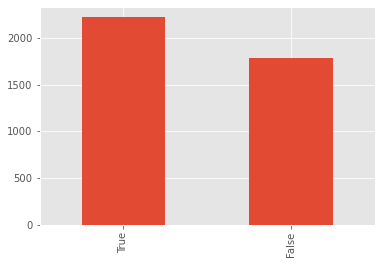

In [37]:

exclusions.metal_salts.value_counts().plot.bar()


<AxesSubplot:>

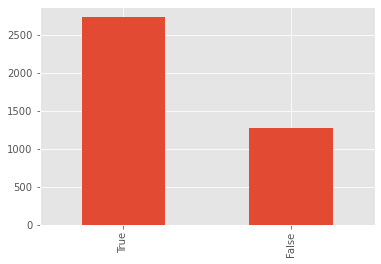

In [38]:
exclusions.inorgs.value_counts().plot.bar()

<AxesSubplot:>

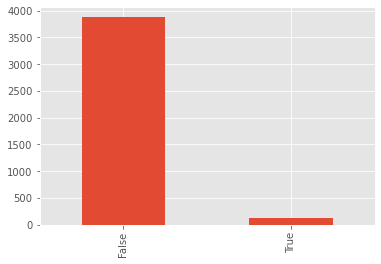

In [39]:
exclusions.inorgP.value_counts().plot.bar()

In [40]:
inorg_filter = []
for x, y, z in list(zip(exclusions['metal_salts'], exclusions['inorgs'], exclusions['inorgP'])):
    if x is True:
        inorg_filter.append('metal_salt')
    elif x is False and y is True:
        inorg_filter.append('inorganic')
    elif z is True:
        inorg_filter.append('inorganic')
    else:
        inorg_filter.append('TTC_NA')
exclusions['inorg_filter'] = inorg_filter

<ipython-input-40-3e9d327af155>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusions['inorg_filter'] = inorg_filter


In [41]:
exclusions[exclusions['inorg_filter'] == 'metal_salt'].head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter
8,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
10,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
13,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
22,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
25,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt


#### Table 2. Counts following re-profiling through the revised inorganic rules 

In [42]:
exclusions.inorg_filter.value_counts()

metal_salt    2220
TTC_NA        1143
inorganic      639
Name: inorg_filter, dtype: int64

In [43]:
exclusions.inorg_filter.count()

4002

In [44]:
exclusions[exclusions['inorg_filter'] == 'TTC_NA' ]['reason_for_NA'].value_counts()

Yes to Q1                  900
High Potency Carcinogen    241
Steroid                      2
Name: reason_for_NA, dtype: int64

In [45]:
exclusions[exclusions['inorg_filter'] == 'TTC_applicable' ]['reason_for_NA'].value_counts()

Series([], Name: reason_for_NA, dtype: int64)

In [46]:
#gentox = pd.read_excel(raw_dir+'kroes_gentox_alerts_120619.xlsx', sheet_name = 'kroes_120619')

In [47]:
#gentox.head()

In [48]:
#alert_dict = { k:v for (k,v) in zip(gentox['Alerts(genotoxic)'], gentox['Alert_Name'])}

### What are the ISS Carc alerts for genotoxicity?

In [49]:
gentox2 = pd.read_csv(raw_dir+'ISS_carc.csv')

In [50]:
gentox2.head()

,ID,Alert_name
0,SA1_gen,Acyl halides
1,SA2_gen,Alkyl (C<5) or benzyl ester of sulphonic or ph...
2,SA3_gen,N-methylol derivatives
3,SA4_gen,Monohaloalkene
4,SA5_gen,S or N mustard


In [51]:
alert_dict2 = { k:v for (k,v) in zip(gentox2['ID'], gentox2['Alert_name'])}

Profiled the LRI exclusions through the ISS alerts to identify what structural alerts are triggered for specific chemicals and which of these fall into the category of HPC or steroids.

In [52]:
gen_alerts = pd.read_csv(raw_dir+'LRIexclusions_180719_4toxtree_outputgentox.csv')

In [53]:
gen_alerts.head()

,DTXSID,Error when applying the decision tree,For a better assessment a QSAR calculation could be applied.,Negative for genotoxic carcinogenicity,Negative for nongenotoxic carcinogenicity,Potential S. typhimurium TA100 mutagen based on QSAR,Potential carcinogen based on QSAR,"QSAR6,8 applicable?",SA10_gen,SA11_gen,...,inorgP,inorg_filter,inorgs,mark_ttc_class,metal_salts,mutant.rules.MutantTreeResult#explanation,old_ttc_class,reason_for_NA,smiles,SMILES
0,DTXSID7021235,NO,NO,NO,YES,NO,NO,NO,NO,NO,...,False,TTC_applicable,True,NA for TTC,True,",SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,...",NA for TTC,Yes to Q1,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,CCN(CC)C1=CC2=[O+]C3=C(C=C(C)C(=C3)N(CC)CC)C(=...
1,DTXSID7021233,NO,NO,NO,YES,NO,NO,NO,NO,NO,...,False,TTC_applicable,True,NA for TTC,True,",SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,...",NA for TTC,Yes to Q1,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,C1=CC=C(C(=C1)C2=C3C=C(C(=O)C(=C3OC4=C2C=C(C(=...
2,DTXSID2041705,NO,YES,NO,NO,NO,NO,YES,NO,NO,...,False,TTC_applicable,True,NA for TTC,True,",SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,...",NA for TTC,Yes to Q1,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,CC1=C(C(=C(C(=C1)C)S(=O)(=O)[O-])C)NC2=CC=C(C3...
3,DTXSID9025328,NO,NO,NO,YES,NO,NO,NO,NO,NO,...,False,TTC_applicable,True,NA for TTC,True,",SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,...",NA for TTC,Yes to Q1,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,C1=CC2=C(C=C1)C3(C4=CC=C(C=C4OC5=CC(=CC=C53)[O...
4,DTXSID1044562,NO,YES,NO,YES,NO,NO,YES,NO,NO,...,False,TTC_applicable,True,NA for TTC,True,",SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,...",NA for TTC,Yes to Q1,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,C1=CC=C(C=C1)N=NC2=C(C=C3C=C(C=C(C3=C2O)N)S(=O...


Create a dictionary to link DTXSIDs to full verbose alert string and then parse to extract those alerts associated with a 'Y' aa being triggered.

In [54]:
alerts = { k:str(v) for (k,v) in zip(gen_alerts['DTXSID'], gen_alerts['mutant.rules.MutantTreeResult#explanation'])}

In [55]:
#alerts

In [56]:
test = gen_alerts['mutant.rules.MutantTreeResult#explanation'].tolist()[0]
print(test)

,SA1_genN,SA2_genN,SA3_genN,SA4_genN,SA5_genN,SA6_genN,SA7_genN,SA8_genN,SA9_genN,SA11_genN,SA12_genN,SA13_genN,SA14_genN,SA15_genN,SA16_genN,SA18_genN,SA19_genY,SA21_genN,SA22_genN,SA23_genN,SA24_genN,SA25_genN,SA26_genN,SA27_genN,SA28_genN,SA28bis_genY,SA28ter_genN,SA29_genN,SA30_genN,SA37_genN,SA38_genN,SA39_gen_and_nogenN,Genotoxic alert?Y,SA10_genN,aN=NaN,ar-N=CH2N,QSAR6,8 applicable?N,SA17_nogenN,SA20_nogenN,SA31a_nogenN,SA31b_nogenN,SA31c_nogenN,SA39_gen_and_nogenN,SA40_nogenN,SA41_nogenN,SA42_nogenN,SA43_nogenN,SA44_nogenN,SA45_nogenN,SA46_nogenN,SA47_nogenN,SA48_nogenN,SA49_nogenN,SA50_nogenN,SA51_nogenN,SA52_nogenN,SA53_nogenN,SA54_nogenN,SA55_nogenN,SA56_nogenN,Nongenotoxic alert?N


Using regex to parse out genotoxicity alerts with a Y (excluding alerts that encode non-genotoxicity information)

In [57]:
import re

In [58]:
re.findall(r'\w+genY',test)

['SA19_genY', 'SA28bis_genY']

In [59]:
prog = re.compile(r'\w+genY')
result = prog.search(test)

In [60]:
#fired_alerts = [m.group(0) for l in alerts.values() for m in [prog.search(l)] if m]

In [61]:
#fired_alerts

In [62]:
test_alerts = {k: m.group(0) for k,v in alerts.items() for m in [prog.search(v)] if m} 

In [63]:
alerts_fired = pd.DataFrame(list(test_alerts.items()), columns = ['DTXSID', 'Alert'])


In [64]:
alerts_fired.head()

,DTXSID,Alert
0,DTXSID7021235,SA19_genY
1,DTXSID7021233,SA19_genY
2,DTXSID2041705,SA12_genY
3,DTXSID9025328,SA18_genY
4,DTXSID1044562,SA29_genY


In [65]:
def removeandreturn(a):
    c = a[-1]
    a = a[:-1]
    return a

In [66]:
 alerts = [removeandreturn(a) for a in alerts_fired['Alert']]

In [67]:
alerts_fired['Genotox_Alert'] =alerts

In [68]:
alerts_fired.drop(['Alert'], axis = 1, inplace = True)

In [69]:
alerts_fired.Genotox_Alert.head()

0    SA19_gen
1    SA19_gen
2    SA12_gen
3    SA18_gen
4    SA29_gen
Name: Genotox_Alert, dtype: object

In [70]:
alerts_fired.Genotox_Alert.unique()

array(['SA19_gen', 'SA12_gen', 'SA18_gen', 'SA29_gen', 'SA3_gen',
       'SA28bis_gen', 'SA30_gen', 'SA27_gen', 'SA21_gen', 'SA10_gen',
       'SA2_gen', 'SA8_gen', 'SA28_gen', 'SA5_gen', 'SA22_gen',
       'SA11_gen', 'SA7_gen', 'SA16_gen', 'SA17_nogen', 'SA13_gen',
       'SA28ter_gen', 'SA38_gen', 'SA23_gen', 'SA47_nogen', 'SA41_nogen',
       'SA53_nogen', 'SA14_gen', 'SA54_nogen', 'SA31a_nogen', 'SA25_gen',
       'SA15_gen', 'SA26_gen', 'SA52_nogen', 'SA24_gen', 'SA31b_nogen',
       'SA43_nogen', 'SA46_nogen', 'SA31c_nogen', 'SA49_nogen',
       'SA42_nogen', 'SA20_nogen', 'SA40_nogen', 'SA44_nogen',
       'SA56_nogen', 'SA50_nogen'], dtype=object)

In [71]:
len([alert_dict2[k] for k in alerts_fired['Genotox_Alert'] if k in alert_dict2])

1417

In [72]:
fired_alerts_names = [alert_dict2[k] for k in alerts_fired['Genotox_Alert'] if k in alert_dict2]
alerts_fired['Fired_Alert_Names'] = fired_alerts_names

In [73]:
alerts_fired.head()

,DTXSID,Genotox_Alert,Fired_Alert_Names
0,DTXSID7021235,SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
1,DTXSID7021233,SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
2,DTXSID2041705,SA12_gen,Quinones
3,DTXSID9025328,SA18_gen,Polycyclic Aromatic Hydrocarbons
4,DTXSID1044562,SA29_gen,Aromatic diazo


In [74]:
#re.findall(r'\w+genY',test)
#[m.group(0) for l in gen_alerts['mutant.rules.MutantTreeResult#explanation'] for m in [prog.findall(l)]]
gen_alerts['mutant.rules.MutantTreeResult#explanation'] = [str(e) for e in gen_alerts['mutant.rules.MutantTreeResult#explanation']]
gen_alert_dict = { k:v for (k,v) in zip(gen_alerts['DTXSID'], gen_alerts['mutant.rules.MutantTreeResult#explanation'])}
#[prog.findall(l) for l in gen_alerts['mutant.rules.MutantTreeResult#explanation'] ]

In [75]:
list_alerts = {k: prog.findall(v) for  k,v in gen_alert_dict.items()} 

In [76]:
list_alerts_df = pd.DataFrame(list(list_alerts.items()), columns = ['DTXSID', 'Alert'])

In [77]:
#[e for i in list_alerts_df['Alert'] for e in i]

In [78]:
list_alerts_df.head()

,DTXSID,Alert
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]"
1,DTXSID7021233,[SA19_genY]
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]"
3,DTXSID9025328,[SA18_genY]
4,DTXSID1044562,[SA29_genY]


In [79]:
out = []
for n, row in list_alerts_df.iterrows():
    for item in row['Alert']:
        row['flat_alert'] =item
        out += [row.copy()]
flat_df = pd.DataFrame(out)

In [80]:
flat_df.head()

,DTXSID,Alert,flat_alert
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA19_genY
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA28bis_genY
1,DTXSID7021233,[SA19_genY],SA19_genY
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA12_genY
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA53_nogenY


In [81]:
len(flat_df)

1637

In [82]:
alerts = [removeandreturn(a) for a in flat_df['flat_alert']]
flat_df['Gentox_alerts'] = alerts

In [83]:
flat_df.drop(['flat_alert'], axis = 1, inplace = True)

In [84]:
alerts_names = [alert_dict2[k] for k in flat_df['Gentox_alerts'] if k in alert_dict2]
flat_df['Fired_Alert_Names'] = alerts_names

In [85]:
flat_df.head()

,DTXSID,Alert,Gentox_alerts,Fired_Alert_Names
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
0,DTXSID7021235,"[SA19_genY, SA28bis_genY]",SA28bis_gen,Aromatic mono- and dialkylamine
1,DTXSID7021233,[SA19_genY],SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones
2,DTXSID2041705,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers


In [86]:
flat_df[flat_df['Fired_Alert_Names'].isnull()]

,DTXSID,Alert,Gentox_alerts,Fired_Alert_Names


In [87]:
exclusions_genetox = pd.merge(exclusions,flat_df, on = 'DTXSID', how = 'left')

In [88]:
len(exclusions_genetox)

4222

In [89]:
exclusions_genetox.columns

Index(['casrn', 'DTXSID', 'name', 'smiles', 'daily_intake', 'iris_noael',
       'tox_cast_oed_5th', 'tox_cast_oed_median', 'tox_tree_ttc', 'ttc_class',
       'kroes_decision', 'small_httk', 'large_cerapp', 'mark_ttc_class',
       'reason_for_NA', 'old_ttc_class', 'metal_salts', 'inorgs', 'inorgP',
       'inorg_filter', 'Alert', 'Gentox_alerts', 'Fired_Alert_Names'],
      dtype='object')

In [90]:
exclusions_genetox[exclusions_genetox['reason_for_NA'] == 'High Potency Carcinogen']

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names
53,101-25-7,DTXSID5020526,"N,N-Dinitrosopentamethylenetetramine",O=NN1CN2CN(C1)CN(C2)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
54,924-16-3,DTXSID2021026,N-Nitrosodibutylamine,CCCCN(CCCC)N=O,99,NaN,0.78521,7.5718,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
66,1116-54-7,DTXSID7021027,N-Nitrosodiethanolamine,OCCN(CCO)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
67,100-75-4,DTXSID8021060,N-Nitrosopiperidine,O=NN1CCCCC1,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
69,55-18-5,DTXSID2021028,N-Nitrosodiethylamine,CCN(CC)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,4549-44-4,DTXSID50196528,N-Ethyl-N-butylnitrosamine,CCCCN(CC)N=O,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
1135,495-48-7,DTXSID0024555,Azoxybenzene,[O-][N+](=Nc1ccccc1)c1ccccc1,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA29_genY],SA29_gen,Aromatic diazo
1138,612-64-6,DTXSID5025786,N-Nitroso-N-ethylaniline,CCN(N=O)c1ccccc1,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups
1142,614-00-6,DTXSID9021053,Nitrosomethylaniline,CN(N=O)c1ccccc1,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,High Potency Carcinogen,NA for TTC,False,False,False,TTC_NA,[SA21_genY],SA21_gen,Alkyl and aryl N-nitroso groups


In [91]:
grpby = exclusions_genetox.groupby('DTXSID')['Fired_Alert_Names'].apply(list).reset_index(name = 'Alerts')

In [92]:
exclusions.head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,kroes_decision,small_httk,large_cerapp,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter
8,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
10,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
13,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
22,518-47-8,DTXSID9025328,Fluorescein sodium,[Na+].[Na+].[O-]c1ccc2c(Oc3cc([O-])ccc3C22OC(=...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt
25,3567-66-6,DTXSID1044562,D&C Red No. 33,[Na+].[Na+].Nc1cc(cc2cc(c(N=Nc3ccccc3)c(O)c12)...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,Risk assessment requires compound-specific tox...,NO,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt


In [93]:
grpby.head()

,DTXSID,Alerts
0,DTXSID00110057,[Polycyclic Aromatic Hydrocarbons]
1,DTXSID00143688,"[Primary aromatic amine, hydroxyl amine and it..."
2,DTXSID00143921,[nan]
3,DTXSID00144074,[Heterocyclic Polycyclic Aromatic Hydrocarbons]
4,DTXSID00144675,[nan]


In [94]:
grpby = grpby.merge(exclusions[['DTXSID', 'name', 'smiles','mark_ttc_class', 'reason_for_NA']] , on = 'DTXSID')

In [95]:
grpby['genetox_alerts'] = grpby['Alerts'].apply(lambda x: '|'.join(map(str,x)))

In [96]:
grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'].unique()

array(['Alkyl and aryl N-nitroso groups',
       'Aliphatic halogens|Alkyl and aryl N-nitroso groups',
       'Aromatic diazo',
       'Alkyl carbamate and thiocarbamate|Aliphatic N-nitro',
       'Aliphatic halogens|Alkyl and aryl N-nitroso groups|Primary aromatic amine, hydroxyl amine and its derived esters (with restrictions)',
       'Aliphatic N-nitro', 'Aliphatic azo and azoxy', 'nan',
       'N-methylol derivatives|Aliphatic azo and azoxy',
       'Aliphatic halogens|Simple aldehyde|Alkyl and aryl N-nitroso groups',
       'Alkyl and aryl N-nitroso groups|Aliphatic N-nitro', 'Hydrazine',
       'Aliphatic halogens|Alkyl and aryl N-nitroso groups|Nitro aromatic',
       'Alkyl and aryl N-nitroso groups|Aromatic nitroso group',
       'Hydrazine|Aliphatic N-nitro',
       'Alkyl and aryl N-nitroso groups|Nitro aromatic',
       'Alkyl and aryl N-nitroso groups|imidazole and benzimidazole',
       'Nitro aromatic',
       'Alkyl and aryl N-nitroso groups|Halogenated benzene  (Nonge

In [97]:
nitroso = re.compile(r'\-nitroso')

In [98]:
azoxy = re.compile(r'\s{1,}azoxy')

In [99]:
test = 'Aliphatic azo and azoxy'

In [100]:
re.findall(r'\s{1,}azoxy', test)

[' azoxy']

Capturing how many of the substances assigned as HPCs contained relevant alerts

In [101]:
len([m.group(0) for v in grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'] for m in [nitroso.search(v)] if m])

204

In [102]:
len([m.group(0) for v in grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'] for m in [azoxy.search(v)] if m])

8

In [103]:
len([m.group(0) for v in grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'] for m in [azoxy.search(v) or nitroso.search(v)] if m ])

212

In [104]:
grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'].value_counts()

Alkyl and aryl N-nitroso groups                                                                                                         171
Aliphatic halogens|Alkyl and aryl N-nitroso groups                                                                                       18
Aliphatic N-nitro                                                                                                                        17
Aliphatic azo and azoxy                                                                                                                   7
Alkyl and aryl N-nitroso groups|Aliphatic N-nitro                                                                                         6
Hydrazine                                                                                                                                 5
Aromatic diazo                                                                                                                            2
Aliphatic halogens|A

#### Identifying those substances that did not flag nitroso or azoxy alerts. 28 substances fired alerts other than nitroso and azoxy and 1 fired no alerts.

In [105]:
chk = grpby[grpby['reason_for_NA'] == 'High Potency Carcinogen']['genetox_alerts'].value_counts().reset_index()

In [106]:
chk[~chk['index'].str.contains('nitroso|azoxy')]

,index,genetox_alerts
2,Aliphatic N-nitro,17
5,Hydrazine,5
6,Aromatic diazo,2
8,Alkyl carbamate and thiocarbamate|Aliphatic N-...,2
11,Hydrazine|Aliphatic N-nitro,1
15,nan,1
17,Nitro aromatic,1


In [107]:
chk[~chk['index'].str.contains('nitroso|azoxy')].sum()

index             Aliphatic N-nitroHydrazineAromatic diazoAlkyl ...
genetox_alerts                                                   29
dtype: object

New representations of HPC

In [108]:
HPC = pd.read_excel(raw_dir+'HPC_230719.xlsx', sheet_name = 'HPC')


In [109]:
HPC

,HPC,SMARTS,ISS_Alert
0,Aflatoxin,COC1=C2C3=C(C(=O)OCC3)C(=O)OC2=C2C3C=COC3OC2=C1,NaN
1,Aflatoxin,O=c1ccc2ccccc2(o1),SA30_gen
2,Aflatoxin,O=C1C=Cc2ccccc2O1,SA30_gen
3,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]=1)[#8]c1c2c2c(c(c1)[O]...,NaN
4,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]1)[#8]c1c2c2c(c([#8][#6...,NaN
5,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]1)[#8]c1c2c2c(c(c1)[O][...,NaN
6,Aflatoxin,[#6]1[#6]2[#6]([#8][#6]=1)[#8]c1c2c2c(c(c1)[O]...,NaN
7,Azoxy,NN=O,NaN
8,Azoxy,"[C,#1]N=[NX2][C,#1]",SA14_gen
9,Azoxy,[$(C=[N+]=[N-]);!$(C=[N+]=[N-]=N);!$(C=[N+]=[N...,SA14_gen


In [110]:
hpc_dict = {}
for i,group in HPC.groupby('HPC'):
    key = [name for name in group['HPC'] if name!=' '][0]
    value = set(group['SMARTS'])
    hpc_dict[key]=value

In [111]:
hpc_smarts = {k : [Chem.MolFromSmarts(s) for s in v] for k,v in hpc_dict.items()}

In [112]:
hpc_smarts

{'Aflatoxin': [<rdkit.Chem.rdchem.Mol at 0x7fbd9a3a9120>,
 'Azoxy': [<rdkit.Chem.rdchem.Mol at 0x7fbd9a3a9a30>,
 'Benzidine': [<rdkit.Chem.rdchem.Mol at 0x7fbd9a39fd00>],
 'Nitroso': [<rdkit.Chem.rdchem.Mol at 0x7fbd9a39f710>,
  <rdkit.Chem.rdchem.Mol at 0x7fbd9a39f210>]}

In [113]:
ex_dict = { k:v for (k,v) in zip(exclusions_genetox['DTXSID'], exclusions_genetox['smiles'])}
ex_smiles = {k : Chem.MolFromSmiles(v) for k,v in ex_dict.items()}

RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:32:28] WARNING: not r

In [114]:
ex_hpc = {x:[k for k, v in hpc_smarts.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in ex_smiles.items()}

In [115]:
ex_hpc_df = pd.DataFrame(list(ex_hpc.items()), columns = ['DTXSID', 'Flag'])

In [116]:

ex_hpc_df['New_Flag']=[tuple(e) for e in ex_hpc_df['Flag']]

#### Figure S2: Countplot of the 4002 substances reprofiled against the revised HPC alerts

In [122]:
squad = ex_hpc_df.New_Flag.value_counts().reset_index()['index'].tolist()

In [139]:
squad = ['No alert', "Azoxy, Nitroso", 'Benzidine', 'Azoxy','Aflatoxin', 'Nitroso']

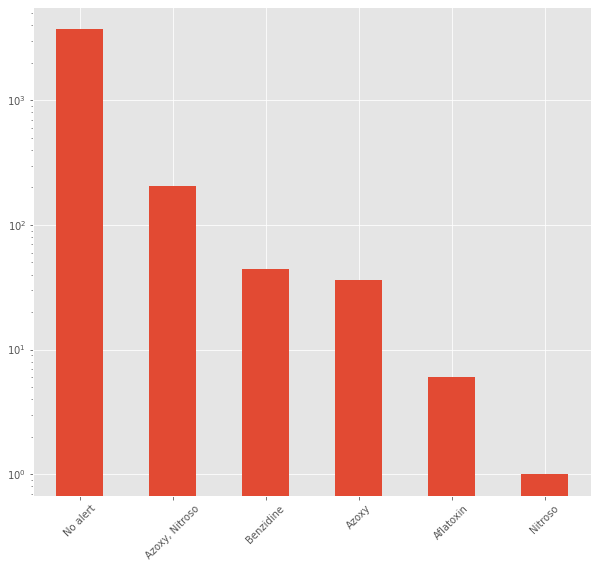

In [141]:
fig, ax = plt.subplots()
ax = ex_hpc_df.New_Flag.value_counts().plot.bar(figsize = (10,9))
ax.set_xticklabels(squad, minor=False, rotation=45)
ax.set_yscale('log');
plt.savefig(figures_dir+'HPC_category_counts_190822.png', dpi = 300, bbox_inches='tight')

In [340]:
ex_hpc_df.shape

(4002, 3)

#### Table 3: Reprofiled 4002 excluded substances based on revised HPC alerts

In [133]:
ex_hpc_df.New_Flag.value_counts()

()                  3708
(Azoxy, Nitroso)     207
(Benzidine,)          44
(Azoxy,)              36
(Aflatoxin,)           6
(Nitroso,)             1
Name: New_Flag, dtype: int64

In [134]:
DLCs2 = pd.read_excel(raw_dir+'HPC_230719.xlsx', sheet_name = 'DLCs2')

In [135]:
dlc_dict2 = { k:v for (k,v) in zip(DLCs2['ID'], DLCs2['SMARTS'])}
dlc_smarts = {k : Chem.MolFromSmarts(v) for k,v in dlc_dict2.items()}

In [136]:
#dlc_dict3 = { k:v for (k,v) in zip(DLCs3['ID'], DLCs3['SMARTS'])}
#dlc_smarts1 = {k : Chem.MolFromSmarts(v) for k,v in dlc_dict3.items()}

In [137]:
dlc_hits2 = ({k: Chem.MolToSmiles(v)  for k,v in ex_smiles.items() if any([v.HasSubstructMatch(e) for e in dlc_smarts.values()])})


In [138]:
dlc_hits2_df = pd.DataFrame(list(dlc_hits2 .items()), columns = ['DTXSID', 'DLC_hit'])

In [139]:
len(dlc_hits2_df)

334

In [140]:
dlc_hits2_df .head()

,DTXSID,DLC_hit
0,DTXSID9036804,Nc1c(S(=O)(=O)[O-])cc2cc(S(=O)(=O)[O-])ccc2c1/...
1,DTXSID90145919,Brc1c(Br)c(Br)c2c(oc3c(Br)c(Br)c(Br)c(Br)c32)c1Br
2,DTXSID7073779,Brc1cc2c(oc3c(Br)c(Br)c(Br)c(Br)c32)c(Br)c1Br
3,DTXSID5073870,Brc1cc2oc3c(Br)c(Br)c(Br)cc3c2cc1Br
4,DTXSID60869478,Brc1cc2oc3cc(Br)c(Br)c(Br)c3c2cc1Br


In [141]:
exclusions_genetox[exclusions_genetox.inorg_filter != 'TTC_NA'].head()

,casrn,DTXSID,name,smiles,daily_intake,iris_noael,tox_cast_oed_5th,tox_cast_oed_median,tox_tree_ttc,ttc_class,...,mark_ttc_class,reason_for_NA,old_ttc_class,metal_salts,inorgs,inorgP,inorg_filter,Alert,Gentox_alerts,Fired_Alert_Names
0,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
1,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA19_genY, SA28bis_genY]",SA28bis_gen,Aromatic mono- and dialkylamine
2,16423-68-0,DTXSID7021233,FD&C Red 3,[Na+].[Na+].[O-]C(=O)c1ccccc1-c1c2cc(I)c([O-])...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,[SA19_genY],SA19_gen,Heterocyclic Polycyclic Aromatic Hydrocarbons
3,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA12_gen,Quinones
4,4474-24-2,DTXSID2041705,C.I. Acid Blue 80,[Na+].[Na+].Cc1cc(C)c(c(C)c1Nc1ccc(Nc2c(C)cc(C...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,"[SA12_genY, SA53_nogenY]",SA53_nogen,Benzensulfonic ethers


In [142]:
temp1 = pd.merge(exclusions_genetox,ex_hpc_df, on = 'DTXSID', how = 'left')

In [143]:
temp2 = pd.merge(temp1, dlc_hits2_df, on = 'DTXSID', how = 'left')

In [144]:
temp3 = temp2.merge(exclusions, on = 'DTXSID')

In [145]:
temp3.DLC_hit = temp3.DLC_hit.replace(np.nan, 'None')

In [146]:
temp3['genotox_flag'] = np.where(temp3.Gentox_alerts.str.contains('_nogen'), 'non_genotox', 'genotox_alert')

In [147]:
temp3.columns

Index(['casrn_x', 'DTXSID', 'name_x', 'smiles_x', 'daily_intake_x',
       'iris_noael_x', 'tox_cast_oed_5th_x', 'tox_cast_oed_median_x',
       'tox_tree_ttc_x', 'ttc_class_x', 'kroes_decision_x', 'small_httk_x',
       'large_cerapp_x', 'mark_ttc_class_x', 'reason_for_NA_x',
       'old_ttc_class_x', 'metal_salts_x', 'inorgs_x', 'inorgP_x',
       'inorg_filter_x', 'Alert', 'Gentox_alerts', 'Fired_Alert_Names', 'Flag',
       'New_Flag', 'DLC_hit', 'casrn_y', 'name_y', 'smiles_y',
       'daily_intake_y', 'iris_noael_y', 'tox_cast_oed_5th_y',
       'tox_cast_oed_median_y', 'tox_tree_ttc_y', 'ttc_class_y',
       'kroes_decision_y', 'small_httk_y', 'large_cerapp_y',
       'mark_ttc_class_y', 'reason_for_NA_y', 'old_ttc_class_y',
       'metal_salts_y', 'inorgs_y', 'inorgP_y', 'inorg_filter_y',
       'genotox_flag'],
      dtype='object')

In [148]:
final_outcome = []
for a,b,c,d in list(zip(temp3['inorg_filter_y'], temp3['DLC_hit'], temp3['New_Flag'], temp3['genotox_flag'] )):
    if a == 'inorganic':
        final_outcome.append('inorganic')
    elif (a != 'inorganic') & (b != 'None'):
        final_outcome.append('DLC')
    elif (a != 'inorganic') & (b == 'None') & (c != ()) :
        final_outcome.append('HPC')
    elif (a != 'inorganic') & (b == 'None') & (c == ()) & (d == 'genotox_alert'):
        final_outcome.append('Genotoxicity Alert')
    else:
        final_outcome.append('other')


In [149]:
temp3['final_TTC_category'] = final_outcome

In [150]:
temp3.final_TTC_category.value_counts()

other                 2350
inorganic              654
Genotoxicity Alert     541
HPC                    343
DLC                    334
Name: final_TTC_category, dtype: int64

In [151]:
temp4 = temp3.drop_duplicates(['DTXSID'], keep = 'first')

In [152]:
#checking for duplicates ad hoc
temp4[temp4['DTXSID'] == 'DTXSID7021235']

,casrn_x,DTXSID,name_x,smiles_x,daily_intake_x,iris_noael_x,tox_cast_oed_5th_x,tox_cast_oed_median_x,tox_tree_ttc_x,ttc_class_x,...,large_cerapp_y,mark_ttc_class_y,reason_for_NA_y,old_ttc_class_y,metal_salts_y,inorgs_y,inorgP_y,inorg_filter_y,genotox_flag,final_TTC_category
0,3520-42-1,DTXSID7021235,C.I. Acid Red 52,[Na+].CCN(CC)c1cc2[o+]c3cc(N(CC)CC)c(C)cc3c(-c...,99,NaN,NaN,NaN,0.000003,Genotoxicity Alert,...,YES,NA for TTC,Yes to Q1,NA for TTC,True,True,False,metal_salt,genotox_alert,Genotoxicity Alert


#### Table 4: Reprofiled substances that were assigned as not applicable for TTC

In [154]:
temp4.final_TTC_category.value_counts()

other                 2249
inorganic              639
Genotoxicity Alert     487
DLC                    334
HPC                    293
Name: final_TTC_category, dtype: int64

In [5]:
#processed_dir = '/home/grace/Documents/python/ttc_exclusions/data/processed/'


'/home/grace/Documents/python/ttc_exclusions/notebooks'

In [369]:
writer = pd.ExcelWriter(interim_dir+'LRIexclusions_output_201021.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
exclusions_genetox.to_excel(writer, sheet_name = 'exclusions_genetox')
#dlc_hits_df.to_excel(writer, sheet_name = 'dlc')
ex_hpc_df.to_excel(writer, sheet_name = 'hpcs')
#logp_pred_df.to_excel(writer, sheet_name = 'logP')
temp3.to_excel(writer, sheet_name = 'final')
temp4.to_excel(writer, sheet_name = 'final_nodups')


writer.save()